# PyTorch use prebuilt dataset

In [1]:
# Import standard libraries that you may use most times
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision import transforms, datasets

print("PyTorch version:", torch.__version__)

PyTorch version: 1.13.1


In [2]:
# Convert Pil image to PyTorch Tensor
data_transform = transforms.Compose([transforms.ToTensor()])

In [3]:
# Load the data set
mnist_train = datasets.MNIST(root='./data', train=True, transform=data_transform, download=True)
mnist_test  = datasets.MNIST(root='./data', train=False,transform=data_transform, download=True)

In [4]:
# Prepare dataloaders
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(mnist_test,  batch_size=64, shuffle=False)

# Explore the data

In [5]:
# Get some random data
next(iter(train_dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [6]:
"Dataset size", len(mnist_train), len(mnist_test)

('Dataset size', 60000, 10000)

In [7]:
"Shape of the samples", next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

('Shape of the samples', torch.Size([64, 1, 28, 28]), torch.Size([64]))

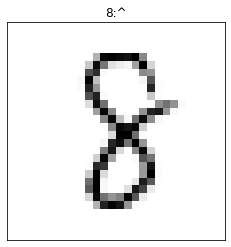

In [8]:
# Plot
def plot_tensor(tensor, label, yh=""):
    plt.imshow(tensor.detach().numpy(), cmap='Greys')
    plt.title ("{}:^{}".format(label.item(),yh));
    plt.tick_params(left= False, labelleft = False , labelbottom = False, bottom = False)
    plt.show()
    
sample = next(iter(train_dataloader))
plot_tensor(sample[0][0].squeeze(), sample[1][0].squeeze())

In [9]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(28 * 28, 128)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2     = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x) # Flatten tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x
    
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model = NeuralNet().to(device)

# Print summary
summary(model, input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 128]                  100,480
├─ReLU: 1-3                              [1, 128]                  --
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 10]                   1,290
├─Softmax: 1-6                           [1, 10]                   --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

In [10]:
# Predict labels using model (untrained)
predictions = model(sample[0][0].to(device)).cpu()
predictions

tensor([[0.0992, 0.1028, 0.0976, 0.1169, 0.0894, 0.1118, 0.0822, 0.1023, 0.1083,
         0.0895]], grad_fn=<ToCopyBackward0>)

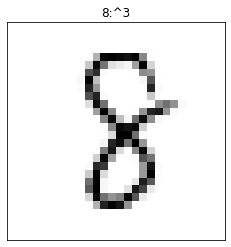

In [11]:
# Plot prediction
p1 = torch.argmax(predictions)

plot_tensor(sample[0][0].squeeze(), sample[1][0].squeeze(),p1.item())

## Train and evaluate your model


In [12]:
# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
CEloos   = nn.CrossEntropyLoss()

In [13]:
# Fit the model
num_epochs = 5

# Iterate over #epochs
for epoch in range(num_epochs):
    # Keep track of network progress
    train_loss    = 0.0
    train_correct = 0
    test_correct  = 0
    
    # Visit each data sample once (random)
    for image, labels in train_dataloader: 
        # Compute model prediction and loss
        pred_labels = model(image.to(device))
        loss        = CEloos(pred_labels, labels.to(device))
        
        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        
        # Add loss to history
        train_loss    += loss.item()
        # Count number of correct predictions 
        train_correct += (torch.argmax(pred_labels.cpu(), 1) == labels.cpu()).sum().item()
    
    # Test loop (once per epoch)
    with torch.no_grad():
        for images, labels in test_dataloader:
            pred_labels = model(images.to(device))
            test_correct += (torch.argmax(pred_labels.cpu(), 1) == labels.cpu()).sum().item()
        
    # Compute accuracy (train & test)
    train_acc = train_correct / len(mnist_train)
    test_acc  = test_correct  / len(mnist_test)
    print('Epoch [{}/{}], Loss: {:.4f}, Train Acc: {:.2f}%, Test Acc: {:.2f}%'
          .format(epoch, num_epochs, train_loss / len(mnist_train), 100 * train_acc, 100 * test_acc))

Epoch [0/5], Loss: 0.0253, Train Acc: 87.35%, Test Acc: 92.44%
Epoch [1/5], Loss: 0.0240, Train Acc: 93.30%, Test Acc: 94.23%
Epoch [2/5], Loss: 0.0238, Train Acc: 94.71%, Test Acc: 95.02%
Epoch [3/5], Loss: 0.0236, Train Acc: 95.53%, Test Acc: 95.46%
Epoch [4/5], Loss: 0.0235, Train Acc: 96.09%, Test Acc: 95.97%


In [14]:
# Sample and plot
samples = next(iter(test_dataloader))[0][:5]
labels  = next(iter(test_dataloader))[1][:5]

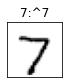

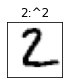

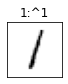

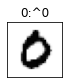

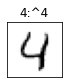

In [15]:
p = [torch.argmax(k) for k in model(samples.to(device))]
for i, l in enumerate(p):
    plt.figure(figsize=(1,1))
    plot_tensor(samples[i].squeeze(), labels[i].squeeze(), p[i].item())
    plt.show()


## Conclusion

Congratulations! on predicting minst data. You have successfully built a neural network to classify handwritten digits with Pytorch. You have achieved accuracy of 96%.